# Description
Train ONN encoders with 3 optical convolutional layers at the frontend (all with non-negative weigths and 64 output channels), 
followed by 2 optical fully connected layers before the bottleneck for the extended cell-organell classification. 

# Load Libraries

In [1]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms
import torchvision

In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=200, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Data loaders

In [3]:
""" Construct a dataset object from data. """

class EBI_Cell_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx]

In [4]:
""" Prepare data loaders """
data = np.load('./EBI_Cells_grey_w_anomaly3.npz')
train_np = data['train_data_grey']
train_labels = data['train_labels']
val_np = data['val_data_grey']
val_labels = data['val_labels']
test_np = data['test_data_grey']
test_labels = data['test_labels']

transforms_digi = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x)])

transforms_digi_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                              transforms.Lambda(lambda x: x.view(-1)), \
                                              transforms.Lambda(lambda x: x)])
kwargs = {}

""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_labels.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(val_labels.shape[0])), \
                                              batch_size=args.test_batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_labels.shape[0])), \
                                             batch_size=10000, drop_last=False)

train_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_np, train_labels, transforms_digi), 
    batch_sampler=train_sampler, **kwargs)

val_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(val_np, val_labels, transforms_digi), 
    batch_sampler=val_sampler, **kwargs)

test_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_np, test_labels, transforms_digi), 
    batch_sampler=test_sampler, **kwargs)

data_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(np.concatenate((test_np, val_np, train_np), axis=0), np.concatenate((test_labels, val_labels, train_labels), axis=0), transforms_digi), 
    batch_size=100000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_sampler=test_sampler, **kwargs)

# train_loader_phys_order = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(train_np, train_labels, transforms_phys), \
#     batch_size=3000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_size=505, shuffle=False, **kwargs)

In [5]:
print(next(enumerate(data_loader))[1][0].shape)
print(next(enumerate(train_loader))[1][0].shape)
print(next(enumerate(val_loader))[1][0].shape)
print(next(enumerate(test_loader))[1][0].shape)

torch.Size([93050, 10000])
torch.Size([128, 10000])
torch.Size([1000, 10000])
torch.Size([9300, 10000])


# NN Models

In [6]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out
    
class ONNConv(nn.Module):
    def __init__(self, ch_in, ch_out, weight_noise=0.02, zeros_init=False, **kwargs):
        super(ONNConv, self).__init__()
        self.conv2d = nn.Conv2d(ch_in, ch_out, **kwargs)
        if zeros_init:
            nn.init.zeros_(self.conv2d.weight)
        else: 
            nn.init.xavier_uniform(self.conv2d.weight)
        self.noise = weight_noise
        
    def forward(self, x):
        self.conv2d.weight.data = self.conv2d.weight.data.clamp_(0,1)
        out = self.conv2d(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device))
        return out
    
def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.relu(torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50)

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [7]:
coeffs = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

class digitalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X

class OpticalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        modules = []
        modules.append(ONNLinear(Nunits[0], Nunits[1], zeros_init=False)) 
        for l in range(1, len(Nunits)-1):
            modules.append(ONNIntensifier(NL_func, self.coeffs))
            modules.append(ONNLinear(Nunits[l], Nunits[l+1], zeros_init=False)) 
        self.encoder_nn = nn.Sequential(*modules)
        compressed_size = Nunits[-1]
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.encoder_nn(x)
        y = self.digifc(x)
        return y
    
class ConvClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(25**2*16, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.meanpool(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [10]:
class ConvClassifier2(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = ONNConv(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(13**2*64, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.meanpool(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [8]:
class ConvClassifier3(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#         self.meanpool1 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.conv2 = ONNConv(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = ONNConv(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn3 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(7**2*64, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
#         x = self.meanpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [10]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[-1E10]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing functions


In [11]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
    accuracy = 100.0 * correct/len(train_loader0.dataset)
    print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = []
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for i, hk in enumerate(hks):
        val_stats[f"fc{i+1}"] = wandb.Histogram(hks[i].output.cpu())      
    
    if epoch%1 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [19]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [128, 256])
    lr_factor0 = 8E-3
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/2, lr_factor0*2)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 0.001, 0.004)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [100, 120, 140])
    model_description = f"cbrmcbrcb_ch64_200_10_b{batch_size}_AdamW_lr_{learning_rate:.6f}_betas_{beta1:.4f}_{beta2:.4f}_swa_{swa_start}_{swa_lr:.4f}" + f"_v_{trial.number}"

    # Instantiate a BNN model
    model = ConvClassifier3([100**2, 200, 10])
    
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+50)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 20:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [20]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [ ]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [3,3,2]
rseeds = [15,306,921]

NAS_project_name = "Jun_30_full_cell_convs3"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader, val_loader)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

15 3
306 3
921 2


(Parallel_NAS_project pid=112357) [I 2022-06-30 12:59:15,882] Using an existing study with name 'Jun_30_full_cell_convs3' instead of creating a new one.
(Parallel_NAS_project pid=112297) [I 2022-06-30 12:59:16,019] Using an existing study with name 'Jun_30_full_cell_convs3' instead of creating a new one.
(Parallel_NAS_project pid=112178) [I 2022-06-30 12:59:16,007] Using an existing study with name 'Jun_30_full_cell_convs3' instead of creating a new one.
(Parallel_NAS_project pid=112297) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=112297)   required=True,
(Parallel_NAS_project pid=112297) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=112297) 2022-06-30 12:59:41.415090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

(Parallel_NAS_project pid=112297) Train Epoch: 1 		Loss: 1.309809	Accuracy:  51.87%


(Parallel_NAS_project pid=112178) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=112178)   required=True,


(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 1, Average loss: 1.1600, Accuracy: 16773/27916(60%)
(Parallel_NAS_project pid=112297) 


(Parallel_NAS_project pid=112357) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=112357) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=112357) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=112357) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220630_125949-3aavwf95
(Parallel_NAS_project pid=112357) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=112357) wandb: Syncing run cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.015770_betas_0.9933_0.9993_swa_140_0.0037_v_23
(Parallel_NAS_project pid=112357) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jun_30_full_cell_convs3
(Parallel_NAS_project pid=112357) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jun_30_full_cell_convs3/runs/3aavwf95
(Parallel_NAS_project pid=112178) wandb: Currently logged in as: gangsterkitty (

(Parallel_NAS_project pid=112297) Train Epoch: 2 		Loss: 1.203556	Accuracy:  61.47%
(Parallel_NAS_project pid=112357) Train Epoch: 1 		Loss: 1.082396	Accuracy:  44.10%


(Parallel_NAS_project pid=112178) 2022-06-30 13:00:05.413113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=112178) 2022-06-30 13:00:05.413166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 2, Average loss: 1.0924, Accuracy: 17596/27916(63%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 1, Average loss: 1.2675, Accuracy: 15687/27916(56%)
(Parallel_NAS_project pid=112357) 


(Parallel_NAS_project pid=112178) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=112178) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=112178) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=112178) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220630_130002-2cxd19kl
(Parallel_NAS_project pid=112178) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=112178) wandb: Syncing run cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.011540_betas_0.9936_0.9993_swa_140_0.0038_v_24
(Parallel_NAS_project pid=112178) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jun_30_full_cell_convs3
(Parallel_NAS_project pid=112178) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jun_30_full_cell_convs3/runs/2cxd19kl


(Parallel_NAS_project pid=112297) Train Epoch: 3 		Loss: 1.443807	Accuracy:  64.51%
(Parallel_NAS_project pid=112357) Train Epoch: 2 		Loss: 0.738332	Accuracy:  56.60%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 3, Average loss: 0.9464, Accuracy: 18956/27916(68%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) Train Epoch: 1 		Loss: 1.177069	Accuracy:  40.97%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 2, Average loss: 1.1827, Accuracy: 16406/27916(59%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 1, Average loss: 1.3727, Accuracy: 13538/27916(48%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) Train Epoch: 4 		Loss: 0.591189	Accuracy:  72.10%
(Parallel_NAS_project pid=112357) Train Epoch: 3 		Loss: 1.069166	Accuracy:  59.63%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112

(Parallel_NAS_project pid=112357) Test set: Epoch 23, Average loss: 0.4104, Accuracy: 24388/27916(87%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) Train Epoch: 21 		Loss: 0.382524	Accuracy:  88.50%
(Parallel_NAS_project pid=112297) Train Epoch: 25 		Loss: 0.844627	Accuracy:  88.75%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 21, Average loss: 0.4060, Accuracy: 24457/27916(88%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 25, Average loss: 0.3930, Accuracy: 24559/27916(88%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 24 		Loss: 0.430137	Accuracy:  88.30%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 24, Average loss: 0.3825, Accuracy: 24761/27916(89%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 26 		Loss: 0.089975	Accuracy:  89.01%
(Pa

(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 46, Average loss: 0.3107, Accuracy: 25168/27916(90%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 45 		Loss: 0.342658	Accuracy:  90.39%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 41, Average loss: 0.3126, Accuracy: 25266/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 45, Average loss: 0.3410, Accuracy: 25082/27916(90%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 47 		Loss: 0.364965	Accuracy:  91.42%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 47, Average loss: 0.3560, Accuracy: 24797/27916(89%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) Train Epoch: 42 		Loss: 0.251884	Accuracy:  91.23%
(Parallel_NAS_project pid=112357) Train Epoch: 46 		L

(Parallel_NAS_project pid=112178) Test set: Epoch 61, Average loss: 0.3025, Accuracy: 25304/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 67, Average loss: 0.2989, Accuracy: 25398/27916(91%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 67 		Loss: 0.078994	Accuracy:  91.36%
(Parallel_NAS_project pid=112178) Train Epoch: 62 		Loss: 0.565763	Accuracy:  92.22%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 67, Average loss: 0.4074, Accuracy: 24453/27916(88%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 68 		Loss: 0.307652	Accuracy:  92.16%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 62, Average loss: 0.2965, Accuracy: 25422/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 68,

(Parallel_NAS_project pid=112178) Train Epoch: 82 		Loss: 0.315515	Accuracy:  92.60%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 82, Average loss: 0.2928, Accuracy: 25444/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) Train Epoch: 88 		Loss: 0.313316	Accuracy:  92.04%
(Parallel_NAS_project pid=112297) Train Epoch: 89 		Loss: 0.418214	Accuracy:  93.26%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 88, Average loss: 0.2805, Accuracy: 25472/27916(91%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 89, Average loss: 0.2867, Accuracy: 25505/27916(91%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) Train Epoch: 83 		Loss: 0.107183	Accuracy:  92.84%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 83, Average loss: 0.2722, Accuracy: 25634/27916(92%)
(Pa

(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 109 		Loss: 0.466114	Accuracy:  92.73%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 102, Average loss: 0.2795, Accuracy: 25570/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 109, Average loss: 0.3020, Accuracy: 25350/27916(91%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 111 		Loss: 0.218758	Accuracy:  93.94%
(Parallel_NAS_project pid=112178) Train Epoch: 103 		Loss: 0.470478	Accuracy:  93.23%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 111, Average loss: 0.2863, Accuracy: 25460/27916(91%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 110 		Loss: 0.110272	Accuracy:  92.70%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 103, Average l

(Parallel_NAS_project pid=112178) Test set: Epoch 122, Average loss: 0.2722, Accuracy: 25653/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) Train Epoch: 132 		Loss: 0.070512	Accuracy:  95.36%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 130, Average loss: 0.2585, Accuracy: 25719/27916(92%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 132, Average loss: 0.2808, Accuracy: 25732/27916(92%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) Train Epoch: 123 		Loss: 0.341028	Accuracy:  94.25%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 123, Average loss: 0.2731, Accuracy: 25574/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) Train Epoch: 131 		Loss: 0.385547	Accuracy:  93.64%
(Parallel_NAS_project pid=112297) Train Epoch: 133 		Loss: 0.662366	Accuracy:  95

(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 151, Average loss: 0.2737, Accuracy: 25560/27916(92%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 153, Average loss: 0.2966, Accuracy: 25549/27916(92%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) Train Epoch: 143 		Loss: 0.287696	Accuracy:  94.85%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 143, Average loss: 0.2652, Accuracy: 25745/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) Train Epoch: 152 		Loss: 0.683391	Accuracy:  94.01%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 152, Average loss: 0.2705, Accuracy: 25659/27916(92%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 154 		Loss: 0.149359	Accuracy:  94.61%
(Parallel_NAS_project pid=112297) 
(Parallel_N

(Parallel_NAS_project pid=112357) Test set: Epoch 172, Average loss: 0.2998, Accuracy: 25490/27916(91%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 174 		Loss: 0.022896	Accuracy:  95.00%
(Parallel_NAS_project pid=112178) Train Epoch: 164 		Loss: 0.194114	Accuracy:  94.21%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 174, Average loss: 0.2972, Accuracy: 25618/27916(92%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 164, Average loss: 0.2859, Accuracy: 25563/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) Train Epoch: 173 		Loss: 0.242296	Accuracy:  94.01%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 173, Average loss: 0.2850, Accuracy: 25574/27916(92%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 175 		Loss: 0.052323	Accuracy:  95

(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 184, Average loss: 0.3046, Accuracy: 25408/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) Train Epoch: 195 		Loss: 0.136808	Accuracy:  95.03%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 195, Average loss: 0.2894, Accuracy: 25630/27916(92%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 194 		Loss: 0.033479	Accuracy:  93.98%
(Parallel_NAS_project pid=112178) Train Epoch: 185 		Loss: 0.009533	Accuracy:  94.62%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 194, Average loss: 0.2844, Accuracy: 25566/27916(92%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 185, Average loss: 0.3154, Accuracy: 25392/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_N

(Parallel_NAS_project pid=112297) [I 2022-06-30 13:35:40,688] Finished trial#22 with value: 92.24888610839844 with parameters: {'batch_size': 128, 'lrf': 0.011486747449610996, 'swa_lr': 0.0039020578522924922, 'beta1': 0.9929421286866439, 'beta2': 0.9992945096216096, 'swa_start': 140}. Best is trial#22 with value: 92.24888610839844.
(Parallel_NAS_project pid=112297) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=112297)   required=True,


(Parallel_NAS_project pid=112357) Train Epoch: 199 		Loss: 0.183558	Accuracy:  94.18%
(Parallel_NAS_project pid=112297) 


(Parallel_NAS_project pid=112297) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=112297) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: / 0.001 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: - 0.001 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: \ 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: | 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: / 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 199, Average loss: 0.2710, Accuracy: 25597/27916(92%)
(Parallel_NAS_project pid=112357) 


(Parallel_NAS_project pid=112297) wandb: - 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: \ 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112297) wandb: | 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
wandb:                                                                                uped)


(Parallel_NAS_project pid=112178) Train Epoch: 190 		Loss: 0.158415	Accuracy:  94.37%


(Parallel_NAS_project pid=112297) wandb: 
(Parallel_NAS_project pid=112297) wandb: Run history:
(Parallel_NAS_project pid=112297) wandb:   accuracy ▁▅▆▆▇▇▇▇█████████▃██████████████████████
(Parallel_NAS_project pid=112297) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=112297) wandb: train_loss █▅▃▃▇▁▄▂▂▂▂▃▃▃▄▂▂▂▁▃▁▁▂▂▂▂▂▃▁▂▂▂▃▂▁▁▂▃▂▂
(Parallel_NAS_project pid=112297) wandb:   val_loss █▅▃▄▃▂▂▂▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
(Parallel_NAS_project pid=112297) wandb: 
(Parallel_NAS_project pid=112297) wandb: Run summary:
(Parallel_NAS_project pid=112297) wandb:   accuracy 91.35263
(Parallel_NAS_project pid=112297) wandb:      batch 436
(Parallel_NAS_project pid=112297) wandb: train_loss 0.13341
(Parallel_NAS_project pid=112297) wandb:   val_loss 0.31543
(Parallel_NAS_project pid=112297) wandb: 
(Parallel_NAS_project pid=112297) wandb: Synced cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.011487_betas_0.9929_0.9993_swa_140_0.0039_v_22: https://wandb.ai/gangst

(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 190, Average loss: 0.2868, Accuracy: 25530/27916(91%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) Train Epoch: 200 		Loss: 0.113908	Accuracy:  94.24%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 200, Average loss: 0.2692, Accuracy: 25675/27916(92%)
(Parallel_NAS_project pid=112357) 


(Parallel_NAS_project pid=112297) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=112297) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=112297) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=112297) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220630_133540-2cjkw026
(Parallel_NAS_project pid=112297) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=112357) [I 2022-06-30 13:35:54,885] Finished trial#23 with value: 92.26250457763672 with parameters: {'batch_size': 128, 'lrf': 0.015769817304402453, 'swa_lr': 0.003748450578251408, 'beta1': 0.993315131176165, 'beta2': 0.9992930686517264, 'swa_start': 140}. Best is trial#23 with value: 92.26250457763672.
(Parallel_NAS_project pid=112297) wandb: Syncing run cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.011782_betas_0.9922_0.9994_swa_140

(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) Train Epoch: 191 		Loss: 0.272026	Accuracy:  94.51%


(Parallel_NAS_project pid=112357) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: / 0.001 MB of 0.076 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: - 0.001 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: \ 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: | 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: / 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: - 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: \ 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112357) wandb: | 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
wandb:                                                                          

(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 191, Average loss: 0.2859, Accuracy: 25587/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) Train Epoch: 1 		Loss: 1.019242	Accuracy:  48.23%


(Parallel_NAS_project pid=112357) wandb: 
(Parallel_NAS_project pid=112357) wandb: Run history:
(Parallel_NAS_project pid=112357) wandb:   accuracy ▁▅▅▆▇▇▇▇▇█▇█▇█▇█████████████████████████
(Parallel_NAS_project pid=112357) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=112357) wandb: train_loss ▆▄█▃▂▃▆▅▄▄▂▃▁▂▃▂▃▃▂▄▂▄▁▆▂▂▃▂▆▄▂▃▄▂▄▃▃▂▁▂
(Parallel_NAS_project pid=112357) wandb:   val_loss █▅▄▃▃▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=112357) wandb: 
(Parallel_NAS_project pid=112357) wandb: Run summary:
(Parallel_NAS_project pid=112357) wandb:   accuracy 91.97234
(Parallel_NAS_project pid=112357) wandb:      batch 436
(Parallel_NAS_project pid=112357) wandb: train_loss 0.11391
(Parallel_NAS_project pid=112357) wandb:   val_loss 0.2692
(Parallel_NAS_project pid=112357) wandb: 
(Parallel_NAS_project pid=112357) wandb: Synced cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.015770_betas_0.9933_0.9993_swa_140_0.0037_v_23: https://wandb.ai/gangste

(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 1, Average loss: 1.1990, Accuracy: 16460/27916(59%)
(Parallel_NAS_project pid=112297) 


(Parallel_NAS_project pid=112357) 2022-06-30 13:36:05.044516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=112357) 2022-06-30 13:36:05.044565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(Parallel_NAS_project pid=112357) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=112357) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=112357) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=112357) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220630_133555-13w0xcbi
(Parallel_NAS_project pid=112357) wandb: Run `wandb offline` to turn off syncing.
(

(Parallel_NAS_project pid=112178) Train Epoch: 192 		Loss: 0.165238	Accuracy:  94.68%
(Parallel_NAS_project pid=112297) Train Epoch: 2 		Loss: 1.144879	Accuracy:  60.05%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 192, Average loss: 0.2632, Accuracy: 25734/27916(92%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 2, Average loss: 1.1098, Accuracy: 17331/27916(62%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 1 		Loss: 1.435417	Accuracy:  43.60%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 1, Average loss: 1.2602, Accuracy: 15691/27916(56%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) Train Epoch: 193 		Loss: 0.077763	Accuracy:  94.61%
(Parallel_NAS_project pid=112297) Train Epoch: 3 		Loss: 0.812916	Accuracy:  62.59%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project p

(Parallel_NAS_project pid=112178) [I 2022-06-30 13:37:46,056] Finished trial#24 with value: 92.21092224121094 with parameters: {'batch_size': 128, 'lrf': 0.01153996913355091, 'swa_lr': 0.003806180759346561, 'beta1': 0.9936305204595622, 'beta2': 0.9992944523997362, 'swa_start': 140}. Best is trial#23 with value: 92.26250457763672.
(Parallel_NAS_project pid=112178) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=112178)   required=True,


(Parallel_NAS_project pid=112297) Train Epoch: 11 		Loss: 0.437279	Accuracy:  81.35%
(Parallel_NAS_project pid=112178) 


(Parallel_NAS_project pid=112178) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=112178) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 11, Average loss: 0.5844, Accuracy: 22864/27916(82%)
(Parallel_NAS_project pid=112297) 


(Parallel_NAS_project pid=112178) wandb: / 0.001 MB of 0.076 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: - 0.001 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: \ 0.080 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: | 0.080 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: / 0.080 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: - 0.080 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: \ 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: | 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: / 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: - 0.087 MB of 0.087 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=112178) wandb: \ 0.087 MB of 0.087 MB uploaded (0.000 

(Parallel_NAS_project pid=112357) Train Epoch: 10 		Loss: 0.781707	Accuracy:  82.73%


(Parallel_NAS_project pid=112178) wandb: 
(Parallel_NAS_project pid=112178) wandb: Run history:
(Parallel_NAS_project pid=112178) wandb:   accuracy ▁▅▆▇▇▇██▇███████████████████████████████
(Parallel_NAS_project pid=112178) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=112178) wandb: train_loss ▇▄▄▇█▄▆▂▂▆▄▁▄▂▂▃▃▄▁▂▁▂▁▁▁▅▂▃▂▂▃▁▂▁▁▂▁▂▂▂
(Parallel_NAS_project pid=112178) wandb:   val_loss █▄▃▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=112178) wandb: 
(Parallel_NAS_project pid=112178) wandb: Run summary:
(Parallel_NAS_project pid=112178) wandb:   accuracy 91.12337
(Parallel_NAS_project pid=112178) wandb:      batch 436
(Parallel_NAS_project pid=112178) wandb: train_loss 0.1417
(Parallel_NAS_project pid=112178) wandb:   val_loss 0.3045
(Parallel_NAS_project pid=112178) wandb: 
(Parallel_NAS_project pid=112178) wandb: Synced cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.011540_betas_0.9936_0.9993_swa_140_0.0038_v_24: https://wandb.ai/gangster

(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 10, Average loss: 0.5425, Accuracy: 23120/27916(83%)
(Parallel_NAS_project pid=112357) 


(Parallel_NAS_project pid=112178) 2022-06-30 13:37:56.412748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=112178) 2022-06-30 13:37:56.412790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(Parallel_NAS_project pid=112297) Train Epoch: 12 		Loss: 0.690042	Accuracy:  82.16%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 12, Average loss: 0.5499, Accuracy: 23171/27916(83%)
(Parallel_NAS_project pid=112297) 


(Parallel_NAS_project pid=112178) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=112178) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=112178) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=112178) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220630_133746-fifjhdbc
(Parallel_NAS_project pid=112178) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=112178) wandb: Syncing run cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.012110_betas_0.9925_0.9994_swa_140_0.0035_v_31
(Parallel_NAS_project pid=112178) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jun_30_full_cell_convs3
(Parallel_NAS_project pid=112178) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jun_30_full_cell_convs3/runs/fifjhdbc


(Parallel_NAS_project pid=112357) Train Epoch: 11 		Loss: 0.408487	Accuracy:  83.62%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 11, Average loss: 0.5232, Accuracy: 23324/27916(84%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112297) Train Epoch: 13 		Loss: 0.662865	Accuracy:  82.74%
(Parallel_NAS_project pid=112178) Train Epoch: 1 		Loss: 1.198785	Accuracy:  46.44%
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 13, Average loss: 0.5724, Accuracy: 22983/27916(82%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 1, Average loss: 1.2540, Accuracy: 15615/27916(56%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112357) Train Epoch: 12 		Loss: 0.764181	Accuracy:  84.11%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 12, Average loss: 0.5370, Accuracy: 23068/27916(83%)
(Para

(Parallel_NAS_project pid=112178) Train Epoch: 21 		Loss: 0.545115	Accuracy:  85.42%
(Parallel_NAS_project pid=112297) Train Epoch: 34 		Loss: 0.374649	Accuracy:  88.23%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112178) Test set: Epoch 21, Average loss: 0.4492, Accuracy: 23991/27916(86%)
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112297) Test set: Epoch 34, Average loss: 0.3704, Accuracy: 24672/27916(88%)
(Parallel_NAS_project pid=112297) 
(Parallel_NAS_project pid=112357) Train Epoch: 33 		Loss: 0.332240	Accuracy:  89.83%
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112357) Test set: Epoch 33, Average loss: 0.4471, Accuracy: 24110/27916(86%)
(Parallel_NAS_project pid=112357) 
(Parallel_NAS_project pid=112178) Train Epoch: 22 		Loss: 0.336877	Accuracy:  85.51%
(Parallel_NAS_project pid=112297) Train Epoch: 35 		Loss: 0.414648	Accuracy:  88.52%
(Parallel_NAS_project pid=112178) 
(Parallel_NAS_project

In [ ]:
ray.shutdown()

# Check inputs

In [26]:
%matplotlib notebook

<IPython.core.display.Javascript object>


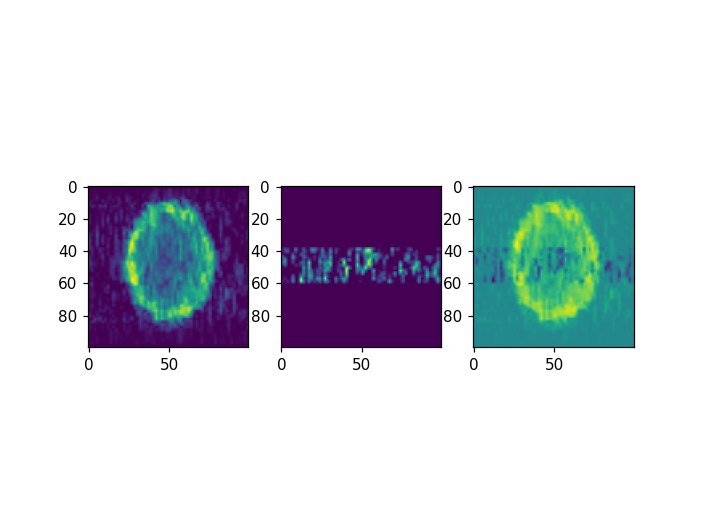

tensor(0)
tensor(1946.3345)


In [27]:
import matplotlib.pyplot as plt

idx = 0
fig, axes = plt.subplots(1,3)
idx = 30
B = next(enumerate(data_loader))[1]
axes[0].imshow(B[0][idx,:].view(100,-1))
axes[1].imshow(train_np[idx,:].reshape(100,-1))
axes[2].imshow(B[0][idx,:].view(100,-1)-train_np[idx,:].reshape(100,-1))
print(B[1][idx])
print(B[0][idx].sum())

<IPython.core.display.Javascript object>


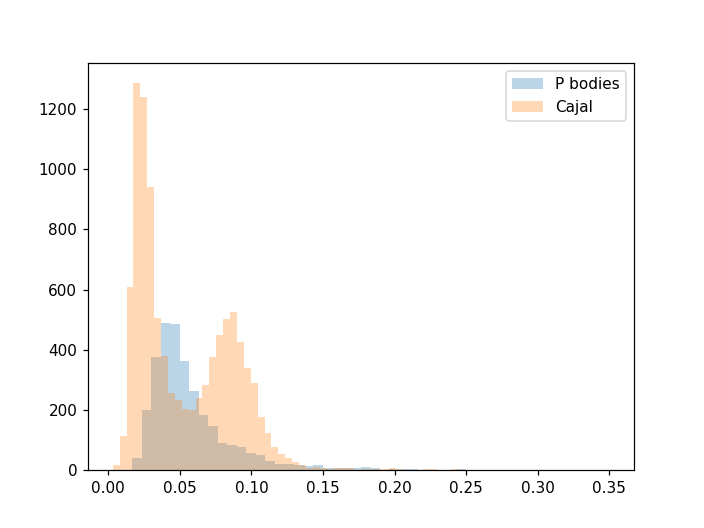

In [48]:
B = next(enumerate(data_loader))[1]
classes = ['cellmask', 'nucleolus', 'centrosome', 'MT', 'cytoplasm', 'ER', 'NE', 'nucleus', 'P bodies', 'Cajal']
id2class = dict(zip(range(10), classes))
ax, fig = plt.subplots(1,1)
for idx, l in enumerate(B[1].unique()[8:10]):
    px_mean = B[0][B[1]==l,:].mean(dim=1)
    plt.hist(px_mean, alpha=0.3, bins=50, label=f"{id2class[l.item()]}")
plt.legend()

# Check nonlinearity

<IPython.core.display.Javascript object>


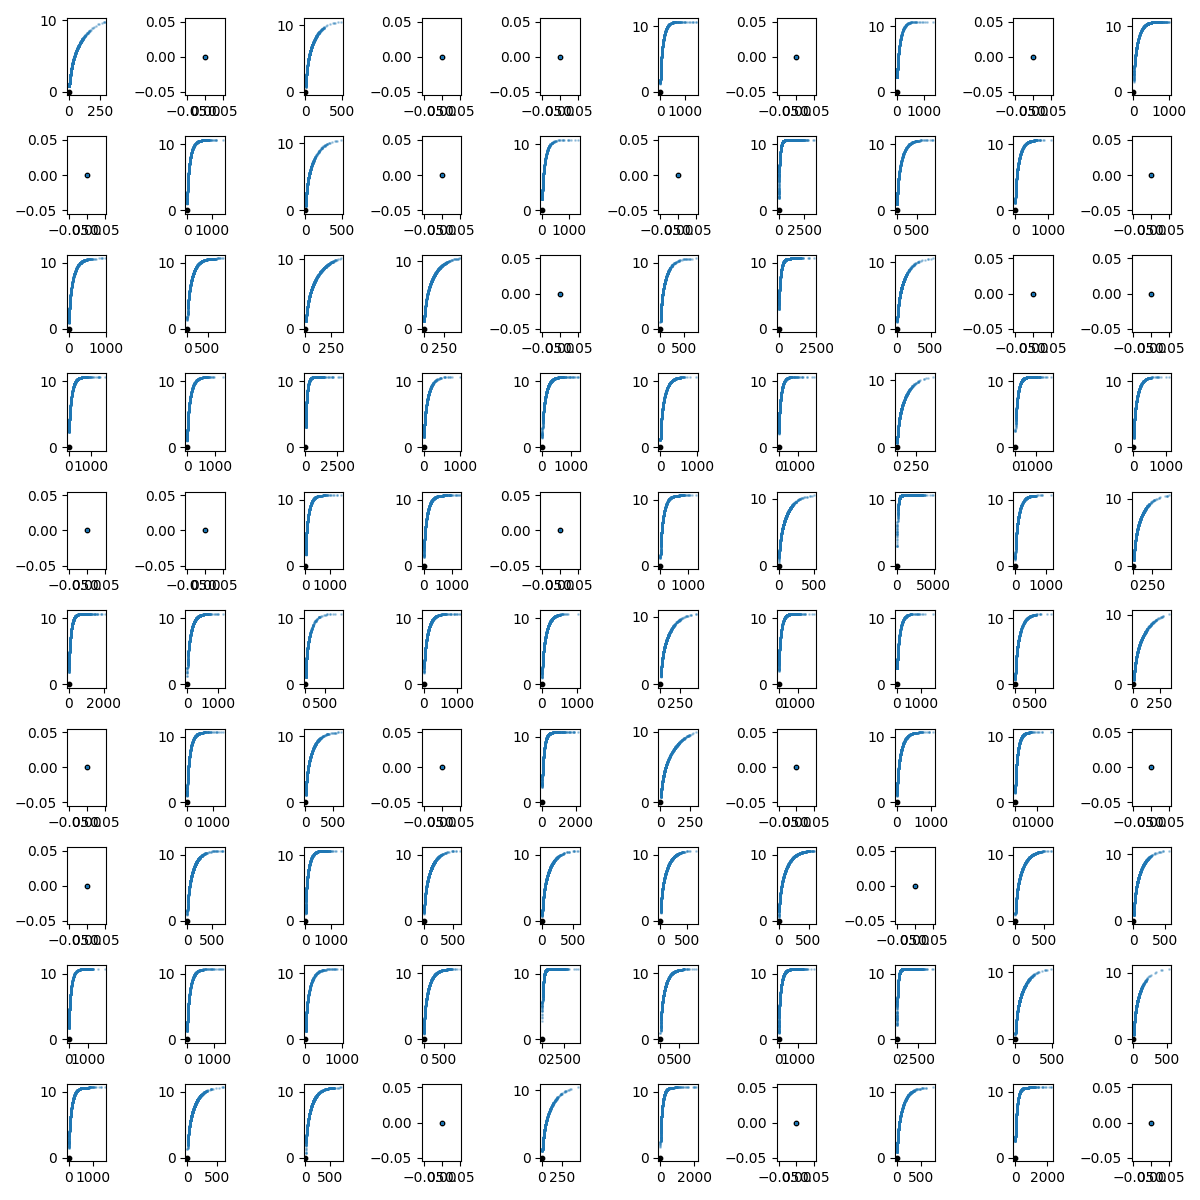

In [131]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(10, 10, figsize = (12, 12))
x0 = torch.arange(0, 400/10, 0.1)
# y0s = model.encoder_nn[1](x0.tile(100,1).T)
# p0s = np.ones((36,4))
# p0s[0,:] = [20, 4, 0, 10]
# p0s[3,:] = [10, 1/3, 1, 1]
# p0s[5,:] = [20, 1/3, 1, 1]
# p0s[8,:] = [100, 1/100, 0, 1]
# p0s[12,:] = [10, 1/2, 0, 1]
# p0s[19,:] = [10, 1/2, 0, 1]
# p0s[23,:] = [20, 1/2, 0, 1]
# p0s[33,:] = [10, 1/2, 0, 1]
# p0s[35,:] = [20, 1/2, 0, 1]
# p0s[:,1] = p0s[:,1]/100
# p0s[:,3] = p0s[:,3]/100
# T1_inv = lambda x: (x+7843.875)/2986.897
# T2_inv = lambda x: x/156575.98
# coeffs_new = np.zeros(p0s.shape)
for k in range(100):
    i = k//10
    j = k%10
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = hkfc1.output[:,k].detach().numpy()
#     y = model.encoder_nn[1](hkfc1.output[:,k]).detach().numpy()
    y = hkact1.output[:,k].detach().numpy()
    ax.scatter(x, y, s=1, alpha=0.3)
#     ax.set_xlabel('Input Intensity')
#     ax.set_ylabel('Output Intensity')
#     popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
#     print(popt)
#     coeffs_new[k,:] = popt
#     coeffs_new[k,0] = coeffs_new[k,0]*50
#     coeffs_new[k,2] = coeffs_new[k,2]*50
#     ax.plot(x0, func2(x0, *coeffs_new[k,:])/50, 'r--')
#     ax.plot(x0, func2(x0, *coeffs_orig[k,:])/50, 'b')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

# Test Runs

In [27]:
b = next(enumerate(test_loader))[1][0]
model = ConvClassifier3([100**2, 200, 10])
x = model.conv1(b.reshape(-1, 1, 100, 100))
x = model.bn1(x)
x = model.relu1(x)
x = model.maxpool1(x)
x = model.conv2(x)
x = model.bn2(x)
x = model.relu2(x)
x = model.conv3(x)
x = model.bn3(x)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [ ]:
args.wandb = True

# model = digitalClassifier([100**2, 1000, 500, 10])
model = ConvClassifier3([100**2, 200, 10])

# with torch.no_grad():
#     model.encoder_nn[0].W_Opt.copy_(torch.tensor(H1/3.2))
#     model.encoder_nn[2].W_Opt.copy_(torch.tensor(H2/10))
#     model.encoder_nn[4].W_Opt.copy_(torch.tensor(H3/10))
    
# model.encoder_nn[0].W_Opt.requires_grad = False
# model.encoder_nn[2].W_Opt.requires_grad = False
# model.encoder_nn[4].W_Opt.requires_grad = False

if args.cuda:
    torch.cuda.set_device(1)
    model.cuda() # transfer the model from cpu to gpu
    
if args.wandb:
    wandb.init(project="Jun_16_fullcell_class", name="cbrmcbrcb_full_200_40_b128_AdamW_lr_0.008_beta_0.99_0.999", reinit=True)
    wandb.watch(model, log="all")

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=8E-3, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
train_loader.batch_sampler.batch_size = 128
for epoch in range(1, 300):
#     if epoch > 3000:
#          model.encoder_nn[0].W_Opt.requires_grad = True
    train(epoch, model, optimizer, criterion, train_loader)
    loss = test(epoch, model, criterion, val_loader)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


accuracy,▅▇▇▇███████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇█▄▂▂▄▃▄▂▂▃▆▁▂▃▁▁▁▂▂▂▁▁▂▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,10.74653
batch,436
train_loss,nan
val_loss,nan


Train Epoch: 1 		Loss: 1.240438	Accuracy:  37.79%

Test set: Epoch 1, Average loss: 1.4750, Accuracy: 13249/27916(47%)

Train Epoch: 2 		Loss: 1.565238	Accuracy:  50.89%

Test set: Epoch 2, Average loss: 1.2935, Accuracy: 15362/27916(55%)

Train Epoch: 3 		Loss: 0.947439	Accuracy:  56.34%

Test set: Epoch 3, Average loss: 1.2156, Accuracy: 16322/27916(58%)

Train Epoch: 4 		Loss: 1.002838	Accuracy:  58.45%

Test set: Epoch 4, Average loss: 1.1801, Accuracy: 16433/27916(59%)

Train Epoch: 5 		Loss: 1.249152	Accuracy:  59.62%

Test set: Epoch 5, Average loss: 1.1425, Accuracy: 17040/27916(61%)

Train Epoch: 6 		Loss: 1.579643	Accuracy:  61.41%

Test set: Epoch 6, Average loss: 1.1012, Accuracy: 17549/27916(63%)

Train Epoch: 7 		Loss: 0.985193	Accuracy:  63.64%

Test set: Epoch 7, Average loss: 1.0324, Accuracy: 18185/27916(65%)

Train Epoch: 8 		Loss: 0.863397	Accuracy:  66.25%

Test set: Epoch 8, Average loss: 0.9478, Accuracy: 19129/27916(69%)

Train Epoch: 9 		Loss: 1.048088	Accuracy

In [132]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"./NonnegConv_Meanpool_OptoFC_200_10_b128_AdamW_lr_0.0008_beta_0.99_0.999.pt")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
